In [122]:
!pip install node2vec


In [123]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import spacy
from tqdm import tqdm
from spacy.matcher import Matcher
import csv
from node2vec import Node2Vec
from sklearn.manifold import TSNE
import numpy as np
from sklearn.cluster import KMeans



nlp = spacy.load("en_core_web_sm")



In [146]:
class Grafo:
    #inicia o grafo criando um gráfico
    def __init__(self):
        self.G = nx.Graph()

    #Recebe um CSV,onde cada linha representa um par de nós e uma aresta entre eles.
    #Pula a primeira linha do arquivo, assumindo que é um cabeçalho.
    #Retorna o grafo self.G após a leitura e adição dos nós e arestas do arquivo CSV.
    def from_csv(self, csv_file, start_line=1, end_line=None, node_column=0, edge_columns=(0, 1)):
        with open(csv_file, 'r') as file:
            reader = csv.reader(file)
            next(reader)  # Skip header row
            for i, row in enumerate(reader):
                if end_line is not None and i >= end_line:
                    break
                elif i >= start_line - 1:  # Adjusted for 0-based indexing
                    name = row[node_column]
                    self.G.add_node(name)
                    for col_idx in edge_columns:
                        if col_idx != node_column:
                            edge_name = row[col_idx]
                            self.G.add_edge(name, edge_name, label='')

        return self.G

    #Exibe o knowledge graph usando o CSV e a def from_csv
    def display(self, csv_file, node_column, edge_columns, num_lines=5):
        # Get column indices from column names
        df = pd.read_csv(csv_file, nrows=1)  # Read only the first row to get column names
        node_column_idx = df.columns.get_loc(node_column)
        edge_column_idxs = [df.columns.get_loc(col) for col in edge_columns]

        G = self.from_csv(csv_file, end_line=num_lines, node_column=node_column_idx, edge_columns=edge_column_idxs)
        pos = nx.spring_layout(G, seed=42, k=0.3)
        labels = nx.get_edge_attributes(G, 'label')

        plt.figure(figsize=(10, 10))
        nx.draw(G, pos, with_labels=True, font_size=8, font_color='black', font_weight='bold', node_size=900,
                node_color='red', edge_color='black', alpha=0.6)
        nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=6, font_color='black', label_pos=0.3,
                                      verticalalignment='baseline')
        plt.title('Knowledge Graph- Pokedex') #Título
        plt.show()

    def numVertices(self):
        return self.G.number_of_nodes()

    def numArestas(self):
        return self.G.number_of_edges()

    def grau(self, Vertice_v):
        return self.G.degree(Vertice_v)

    def verticesAdjacentes(self, Vertice_v):
        return list(self.G.neighbors(Vertice_v))

    def arestasIncidentes(self, Vertice_v):
        return list(self.G.edges(Vertice_v))

    def saoAdjacentes(self, Vertice_v, Vertice_w):
        return self.G.has_edge(Vertice_v, Vertice_w)

    def insereVertice(self, Vertice_v):
        self.G.add_node(Vertice_v)

    def insereAresta(self, Vertice_v, Vertice_w):
        self.G.add_edge(Vertice_v, Vertice_w)

    def removeVertice(self, Vertice_v):
        self.G.remove_node(Vertice_v)

    def removeAresta(self, Vertice_v, Vertice_w):
        self.G.remove_edge(Vertice_v, Vertice_w)

    #calcula e visualiza medidas de centralidade para os nós do grafo
    def calculate_and_visualize_centrality(self):
        pos = nx.spring_layout(self.G, seed=42, k=0.3)

        # Calcula medidas de centralidade
        degree_centrality = nx.degree_centrality(self.G)
        betweenness_centrality = nx.betweenness_centrality(self.G)
        closeness_centrality = nx.closeness_centrality(self.G)

        # Visualiza as medidas
        plt.figure(figsize=(15, 10))

        # Degree centrality
        plt.subplot(131)
        nx.draw(self.G, pos, with_labels=True, font_size=10, node_color='green', node_size=[v * 3000 for v in degree_centrality.values()])
        plt.title('Degree Centrality')

        # Betweenness centrality
        plt.subplot(132)
        nx.draw(self.G, pos, with_labels=True, font_size=10, node_color='skyblue', node_size=[v * 3000 for v in betweenness_centrality.values()])
        plt.title('Betweenness Centrality')

        # Closeness centrality
        plt.subplot(133)
        nx.draw(self.G, pos, with_labels=True, font_size=10, node_color='red', node_size=[v * 3000 for v in closeness_centrality.values()])
        plt.title('Closeness Centrality')

        plt.tight_layout()
        plt.show()


    #gera e visualiza os embeddings(representações vetoriais de nós) de nós em um espaço bidimensional usando o algoritmo t-Distributed Stochastic Neighbor Embedding (t-SNE)
    def visualize_node_embeddings(self, dimensions=64, walk_length=30, num_walks=200, window=10, min_count=1, batch_words=4, perplexity=10, n_iter=400):
        # Generate node embeddings using node2vec
        node2vec = Node2Vec(self.G, dimensions=dimensions, walk_length=walk_length, num_walks=num_walks, workers=4)
        model = node2vec.fit(window=window, min_count=min_count, batch_words=batch_words) # Training the model

        # Get embeddings for all nodes
        embeddings = np.array([model.wv[node] for node in self.G.nodes()])

        # Reduce dimensionality using t-SNE
        tsne = TSNE(n_components=2, perplexity=perplexity, n_iter=n_iter)
        embeddings_2d = tsne.fit_transform(embeddings)

        # Visualize embeddings in 2D space with node labels
        plt.figure(figsize=(12, 10))
        plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c='blue', alpha=0.7)

        # Add node labels
        for i, node in enumerate(self.G.nodes()):
            plt.text(embeddings_2d[i, 0], embeddings_2d[i, 1], node, fontsize=8)

        plt.title('Node Embeddings Visualization')
        plt.show()

    #executa o algoritmo de clustering K-Means nos embeddings de nós fornecidos e visualiza os resultados no espaço de embedding 2D.
    def kmeans_clustering(self, embeddings, embeddings_2d, num_clusters=3, colormap='plasma'):

        # Perform K-Means clustering on node embeddings
        kmeans = KMeans(n_clusters=num_clusters, random_state=42)
        cluster_labels = kmeans.fit_predict(embeddings)

        # Visualize K-Means clustering in the embedding space with node labels
        plt.figure(figsize=(12, 10))
        plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=cluster_labels, cmap=colormap)
        # Add node labels
        for i, node in enumerate(self.G.nodes()):
            plt.text(embeddings_2d[i, 0], embeddings_2d[i, 1], node, fontsize=8)
        plt.title('K-Means Clustering in Embedding Space with Node Labels')
        plt.colorbar(label="Cluster Label")
        plt.show()

    #Visualiza os clusters no grafo
    def kmeans_clustering_and_visualization(self, embeddings, pos, num_clusters=3):
        """
        Perform K-Means clustering on node embeddings and visualize clusters on the graph.

        Parameters:
            embeddings (numpy.ndarray): Node embeddings.
            pos (dict): Node positions for visualization.
            num_clusters (int): Number of clusters for K-Means.
        """
        # Perform K-Means clustering on node embeddings
        kmeans = KMeans(n_clusters=num_clusters, random_state=42)
        cluster_labels = kmeans.fit_predict(embeddings)

        # Visualize clusters on the graph
        plt.figure(figsize=(12, 10))
        nx.draw(self.G, pos, with_labels=True, font_size=10, node_size=700, node_color=cluster_labels, cmap='viridis')
        plt.title('Graph Clustering using K-Means')
        plt.show()






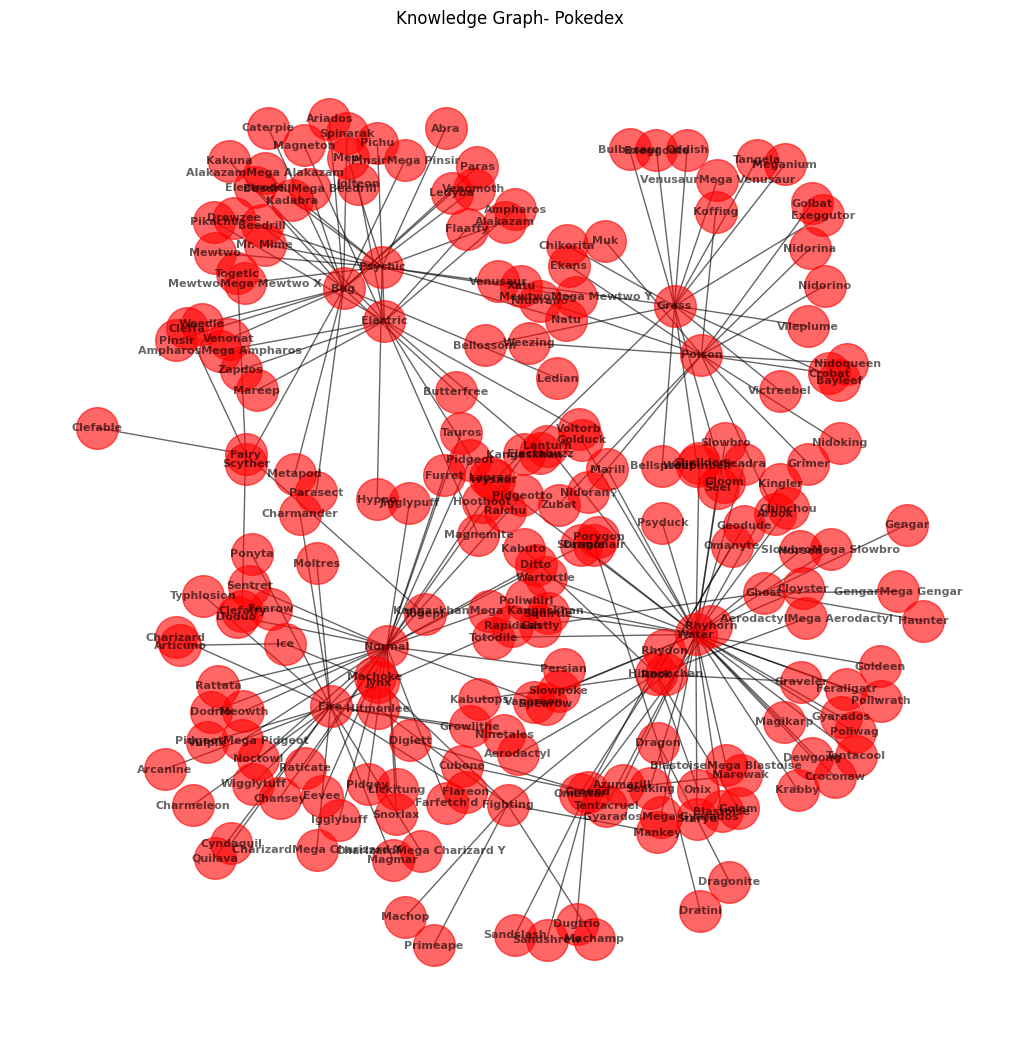

In [184]:
grafo = Grafo()
grafo.display('pokemon.csv', node_column='Name', edge_columns=('Name', 'Type 1'), num_lines=200)


Número de vértices: 59
Número de arestas: 50
Grau do vértice 'Pikachu': 1
Grau do vértice 'Raichu': 1
Vértices adjacentes de 'Raichu': ['Electric']
Arestas incidentes em 'Raichu': [('Raichu', 'Electric')]
'Pikachu' e 'Raichu' são adjacentes? False
Número de vértices após remoção: 58
Número de arestas após remoção: 49


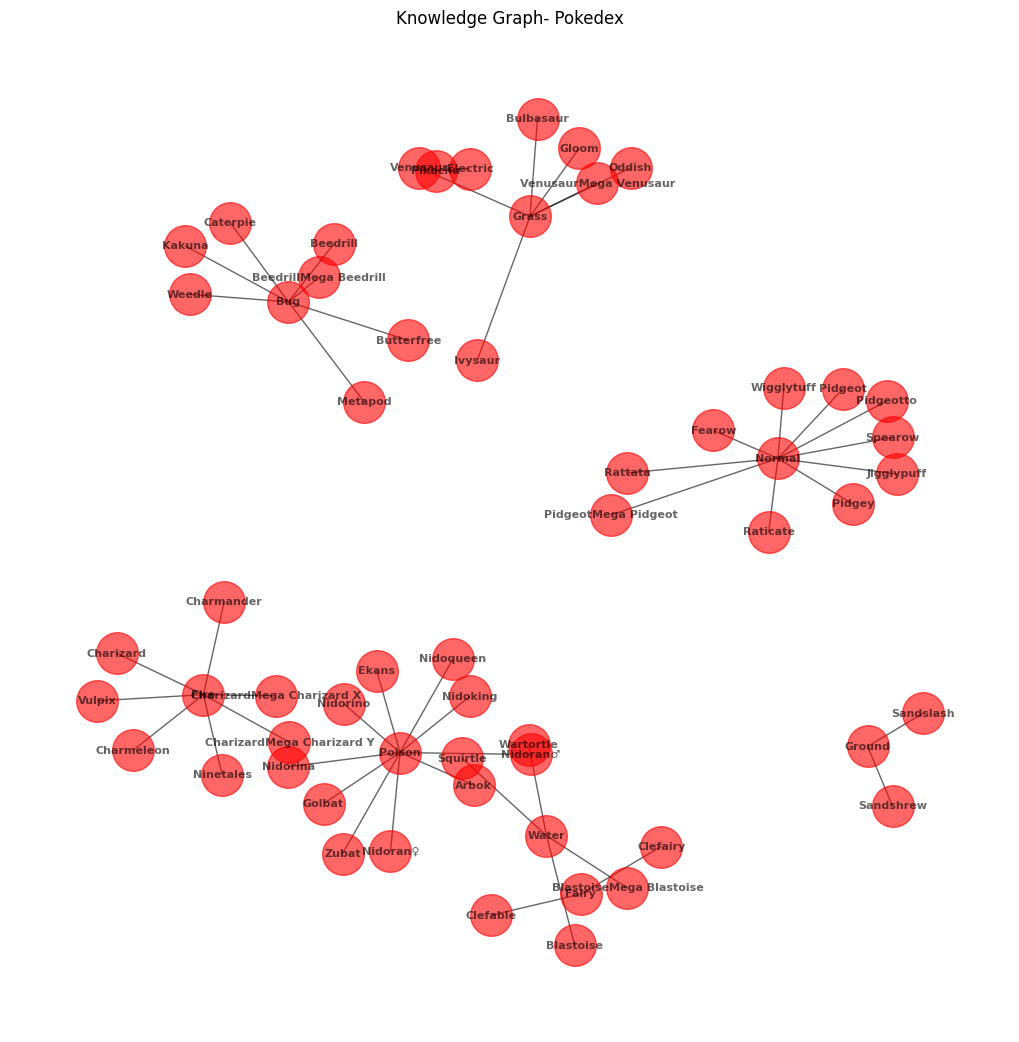

In [181]:
# Exibindo o número de vértices e arestas do grafo
print("Número de vértices:", grafo.numVertices())
print("Número de arestas:", grafo.numArestas())

# Verificando o grau de alguns vértices
print("Grau do vértice 'Pikachu':", grafo.grau('Pikachu'))
print("Grau do vértice 'Raichu':", grafo.grau('Raichu'))

# Verificando os vértices adjacentes de 'Raichu'
print("Vértices adjacentes de 'Raichu':", grafo.verticesAdjacentes('Raichu'))

# Verificando as arestas incidentes em 'Raichu'
print("Arestas incidentes em 'Raichu':", grafo.arestasIncidentes('Raichu'))

# Verificando se 'Pikachu' e 'Raichu' são adjacentes
print("'Pikachu' e 'Raichu' são adjacentes?", grafo.saoAdjacentes('Pikachu', 'Raichu'))

# Removendo o vértice 'Raichu'
grafo.removeVertice('Raichu')

# Exibindo o número de vértices e arestas após a remoção
print("Número de vértices após remoção:", grafo.numVertices())
print("Número de arestas após remoção:", grafo.numArestas())

# Exibindo o grafo após as alterações
grafo.display('pokemon.csv', node_column='Name', edge_columns=('Name', 'Type 1'))


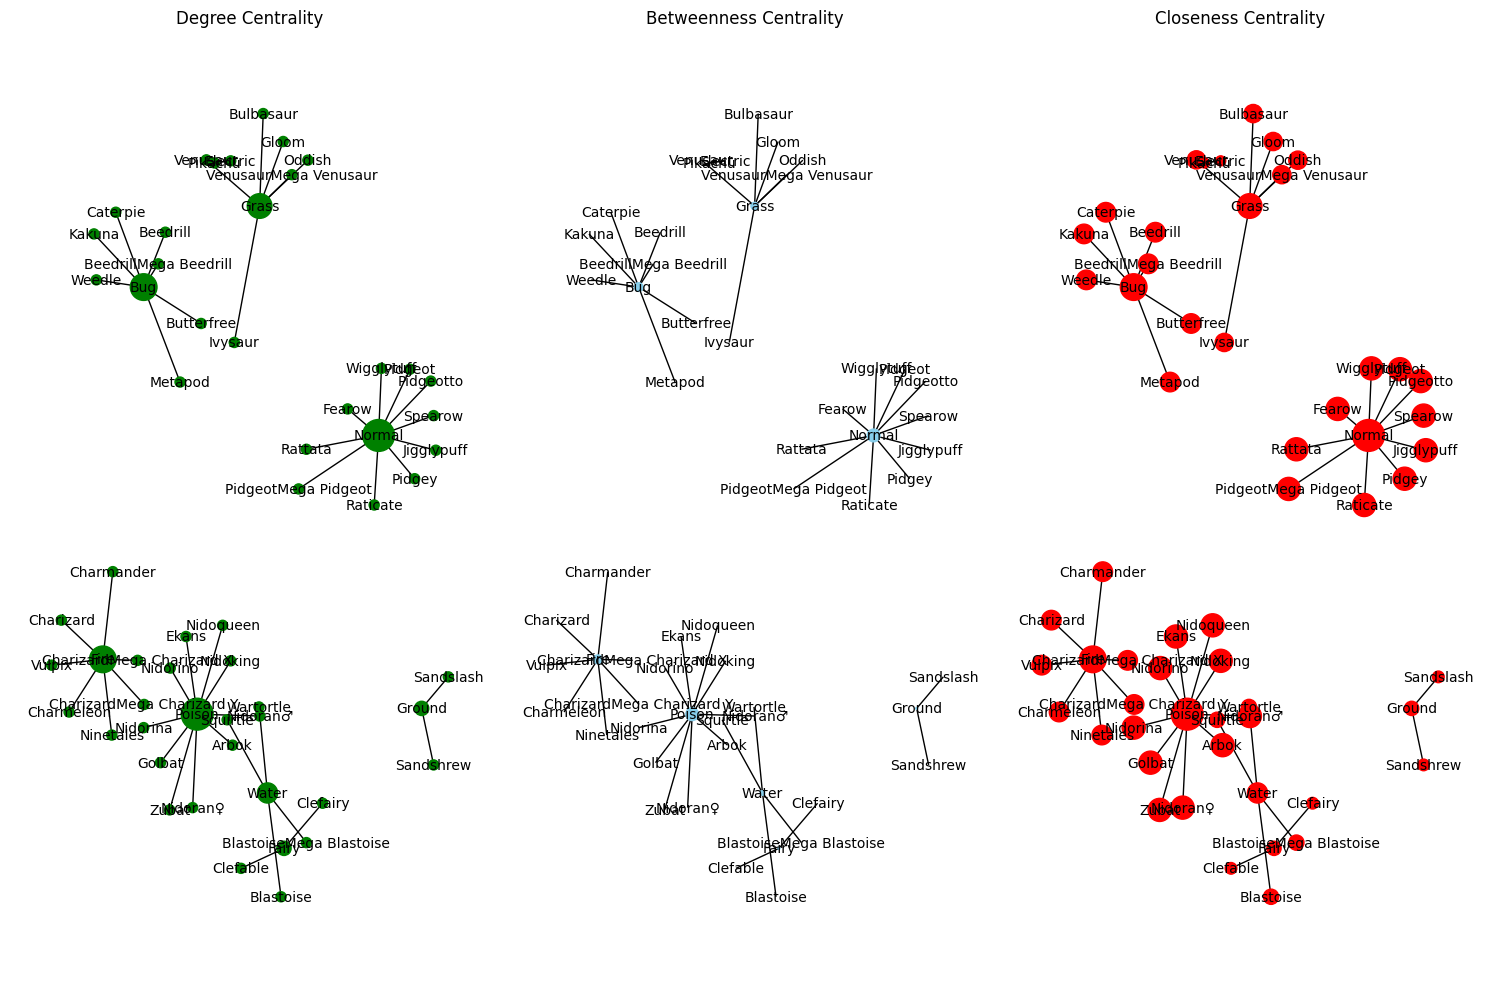

In [171]:
grafo.calculate_and_visualize_centrality()

Computing transition probabilities:   0%|          | 0/58 [00:00<?, ?it/s]

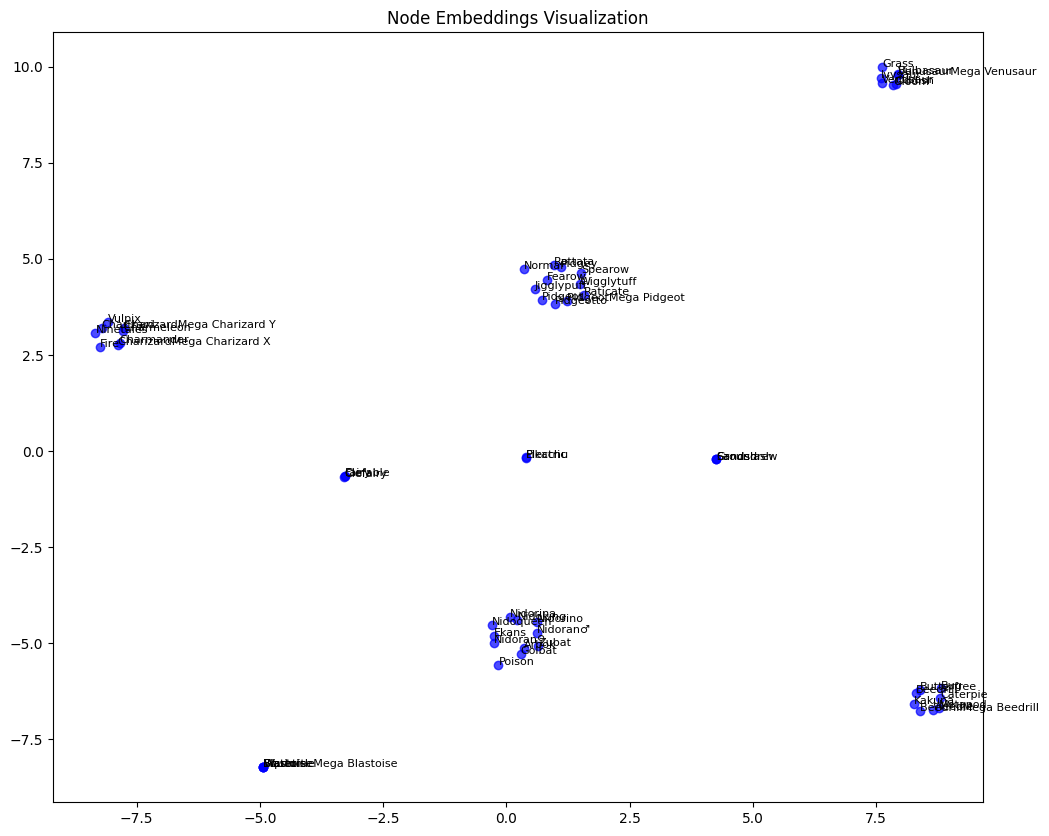

In [172]:
grafo.visualize_node_embeddings()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


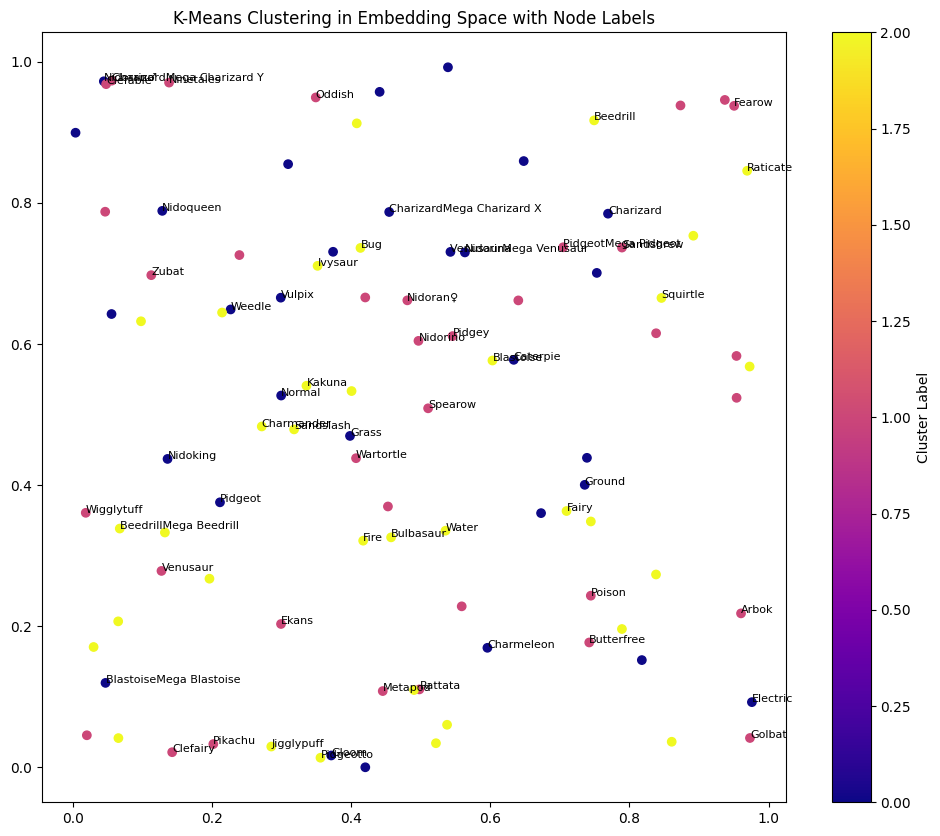

In [173]:
embeddings = np.random.rand(100, 64)
embeddings_2d = np.random.rand(100, 2)

num_clusters = 3

grafo.kmeans_clustering(embeddings, embeddings_2d, num_clusters=num_clusters, colormap='plasma')



In [174]:
num_nodes_grafo = len(grafo.G.nodes())
print("Número de nós no grafo:", num_nodes_grafo)

# Verificar o número de pontos nas matrizes de embeddings e coordenadas 2D
num_pontos_embeddings = embeddings.shape[0]
num_pontos_embeddings_2d = embeddings_2d.shape[0]
print("Número de pontos nas matrizes de embeddings:", num_pontos_embeddings)
print("Número de pontos nas matrizes de coordenadas 2D:", num_pontos_embeddings_2d)


Número de nós no grafo: 58
Número de pontos nas matrizes de embeddings: 100
Número de pontos nas matrizes de coordenadas 2D: 100


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


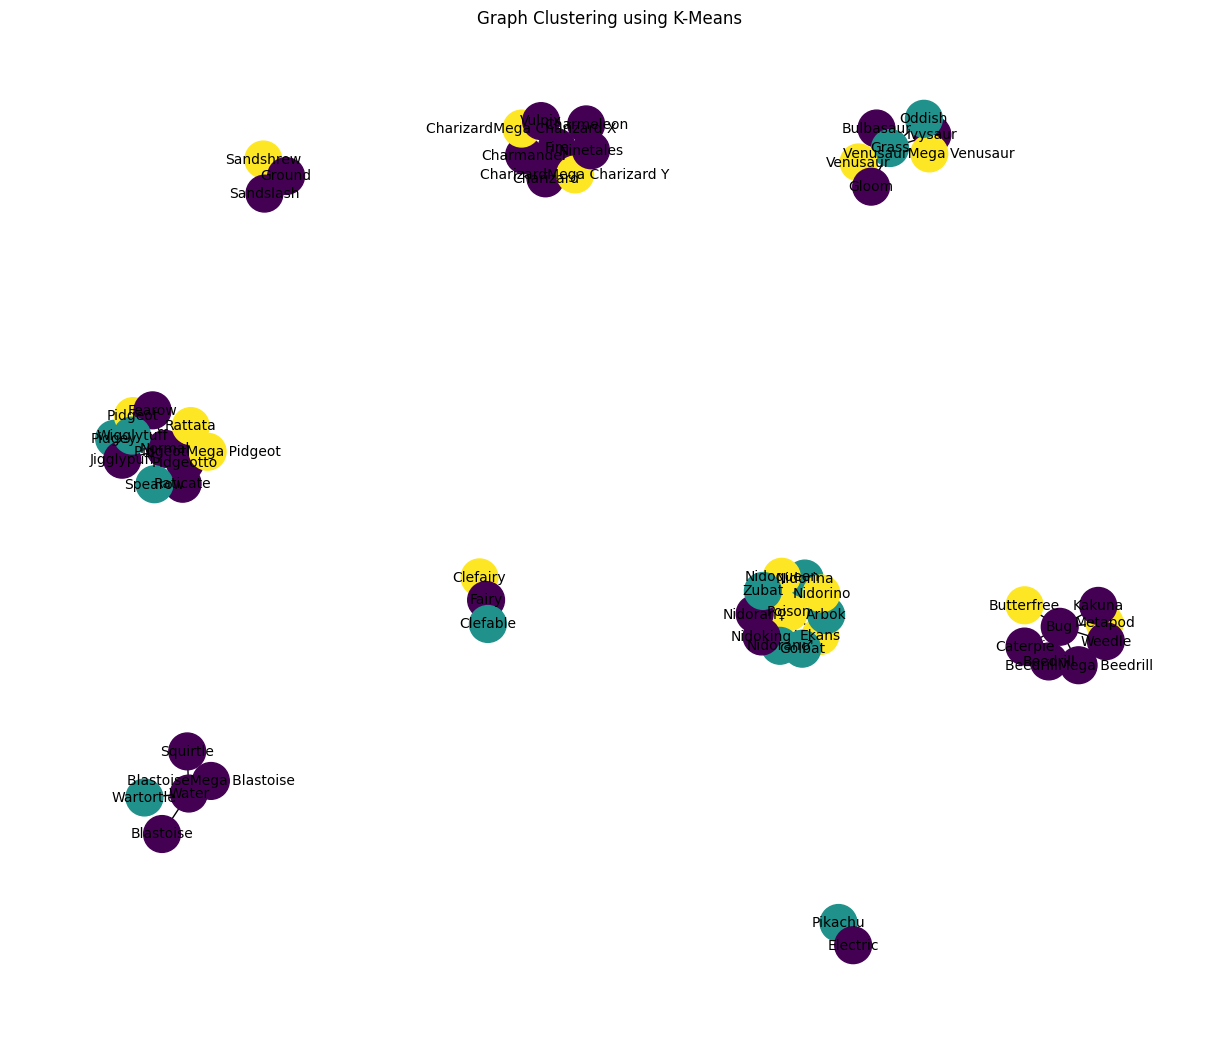

In [175]:
# Reduzir as matrizes de embeddings e coordenadas 2D para conterem apenas os dados correspondentes aos nós presentes no grafo
embeddings = embeddings[:num_nodes_grafo]
embeddings_2d = embeddings_2d[:num_nodes_grafo]

# Realizando o clustering K-Means e visualizando os clusters no grafo
grafo.kmeans_clustering_and_visualization(embeddings, pos, num_clusters=3)


